In [82]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.neighbors import KernelDensity
from datetime import datetime, date


In [2]:
# Read Robbery data, add month and year columns
fulldf = pd.read_pickle('../data/robbery-street.p')
fulldf['month'] = fulldf.date.apply(lambda x: x.month)
fulldf['year'] = fulldf.date.apply(lambda x: x.year)

# Join with weather
weather = pd.read_pickle(r"../data/noaa-weather-downtown-sf.p")
fulldf = fulldf.merge(weather,how="inner",left_on="date",right_on="DATE")

df = fulldf[fulldf.year < 2016]

## Yearly counts

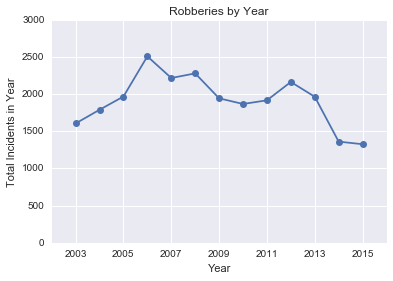

In [115]:
yearlytotal = df.year.value_counts().to_frame(name="count").sort_index()
yearlytotal['year'] = yearlytotal.index
plt.plot(yearlytotal['year'],yearlytotal['count'],'o-')
plt.xlabel('Year')
plt.ylabel('Total Incidents in Year')
plt.title('Robberies by Year')
plt.axis([2002, 2016, 0, 3000])
plt.xticks(range(2003,2016,2), range(2003,2016,2))
pass

## Aggregated by month

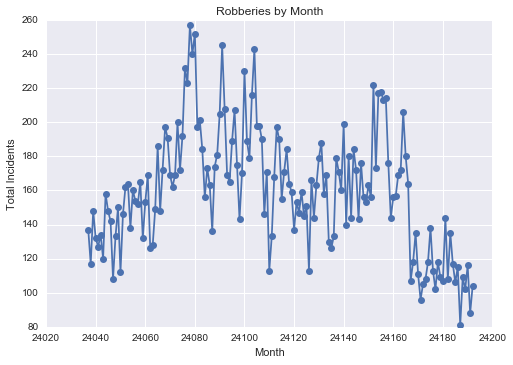

In [4]:
def monthyear2num(month,year):
    return year*12 + month

def num2monthyear(num):
    month = num % 12
    year = (num-month) / 12
    return "%.2d/%.2d" % (month,year)

groupbyyearmonth = df[['year','month']].groupby(by=['year','month']).size().to_frame(name="count")
groupbyyearmonth.reset_index(inplace=True)
groupbyyearmonth['monthyear'] = groupbyyearmonth.apply(lambda row: row['year']*12 + row['month'],axis=1)

plt.plot(groupbyyearmonth['monthyear'],groupbyyearmonth['count'],'o-')
plt.xlabel('Month')
plt.ylabel('Total Incidents')
plt.title('Robberies by Month')
pass

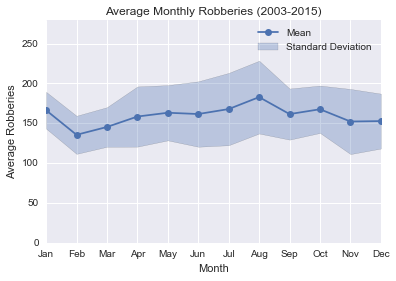

In [111]:
groupbymonth = groupbyyearmonth[['month','count']].groupby(by='month')
groupbymonth = groupbymonth['count'].agg({'sum' : sum, 'mean' : np.mean, 'std' : np.std})
plot_mean = plt.plot(groupbymonth.index,groupbymonth['mean'],'o-')
plot_std = plt.fill_between(groupbymonth.index, 
                 groupbymonth['mean']-groupbymonth['std'], 
                 groupbymonth['mean']+groupbymonth['std'],
                 alpha=.3)
plt.xlabel('Month')
plt.ylabel('Average Robberies')
plt.title('Average Monthly Robberies (2003-2015)')
plt.legend(['Mean','Standard Deviation'])
plt.axis([1, 12, 0, 280])
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
plt.xticks(range(1,13,1), months)
pass


## Aggregated by time of day

[0, 1440, 0, 0.002]

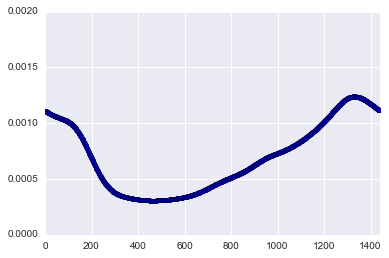

In [125]:
def scott_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 1.06*sigma*S.count()**(-0.2)

def silverman_bw(S):
    iqr = np.subtract(*np.percentile(S, [75, 25]))
    sigma = min(S.std(),iqr)
    return 0.9*sigma*S.count()**(-0.2)

class WrappedKDE:
    
    def __init__(self,S):
        # S is a pandas series
        self.bandwidth = silverman_bw(S)
        self.model = KernelDensity(bandwidth=self.bandwidth)
        return None
        
    def fit(self,data):
        self.model.fit(data.reshape(-1,1))
        return self
    
    def pdf(self,grid):
        grid = grid.reshape(-1,1)
        griddelta = grid[1]-grid[0]
        gridmax = grid[-1]+griddelta
        out = np.exp(self.model.score_samples(grid))
        out += np.exp(self.model.score_samples(grid-gridmax))
        out += np.exp(self.model.score_samples(grid+gridmax))
        return out

timekde = WrappedKDE(df.time.apply(time2num))
timekde.fit(df.time.apply(time2num))
plt.scatter(timegrid, timekde.pdf(timegrid))
plt.axis([0, 1440, 0, 0.002])

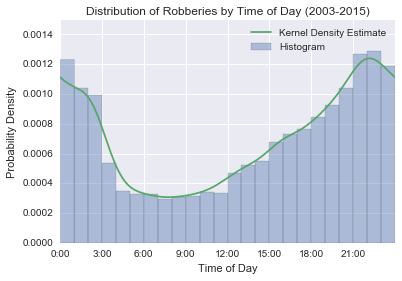

In [126]:
def time2num(t):
    ts = t.hour * 60 + t.minute
    return ts
hours = ['0:00','3:00','6:00','9:00','12:00','15:00','18:00','21:00','24:00']
#plt.hist(df.time.apply(time2num),bins=24,normed=True,alpha=0.5)
sns.distplot(df.time.apply(time2num),kde = False,norm_hist=True,bins=24)
plt.plot(timegrid,timekde.pdf(timegrid),'-')
plt.axis([0,1440,0,0.0015])
plt.xticks(range(0,1440,180), hours)

plt.xlabel('Time of Day')
plt.ylabel('Probability Density')
plt.title('Distribution of Robberies by Time of Day (2003-2015)')
plt.legend(['Kernel Density Estimate','Histogram'])
pass

## Aggregation by spatial location

In [127]:
def silverman_bwxy(df):
    count = df['x'].count()
    stdx = df['x'].std()
    stdy = df['y'].std()
    iqrx = np.subtract(*np.percentile(df['x'], [75, 25]))
    iqry = np.subtract(*np.percentile(df['y'], [75, 25]))
    sigma = min(stdx,stdy,iqrx,iqry)
    return 0.9*sigma*count**(-0.2)

spacekde = KernelDensity(bandwidth = silverman_bwxy(df[['x','y']]),metric='haversine')
spacekde.fit(df[['x','y']])


KernelDensity(algorithm='auto', atol=0, bandwidth=0.0026073070785577511,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='haversine', metric_params=None, rtol=0)

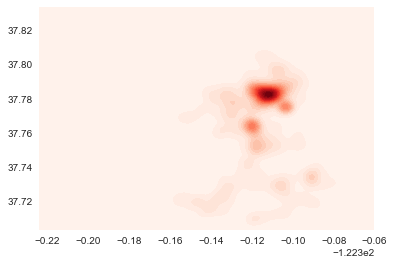

In [130]:
xmin = -122.5237517
xmax = -122.3602017
ymin = 37.7040012
ymax = 37.8341382

xv, yv = np.meshgrid(np.linspace(xmin,xmax,num=200),np.linspace(ymin,ymax,num=200))

X_grid = np.vstack([xv.ravel(), yv.ravel()]).transpose()



Z = np.exp(spacekde.score_samples(X_grid))
Z = Z.reshape(xv.shape)

levels = np.linspace(Z.min(), Z.max(), 25)
plt.contourf(xv, yv, Z, levels=levels, cmap=plt.cm.Reds)

In [132]:
Z = np.exp(spacekde.score_samples(X_grid))
Z.shape

(40000,)

In [145]:
def toheatarray(X,Z):
    return [[point[0], point[1], point[2]] for point in zip(X[:,0],X[:,1],Z)]